In [3]:
import matplotlib.pyplot as plt
import skimage.io as io

from models.models import *
from models.UNet import UNet2D

import torch
from skimage import graph, data, io, segmentation, color, filters
from skimage.measure import regionprops
from skimage import draw
from skimage.segmentation import relabel_sequential
import numpy as np
from random import shuffle
import skimage.future.graph as graph

from super_pixel import RAG

In [4]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [5]:
def show_img(img, size=5):
    f = plt.figure(figsize=(size, size))
    plt.imshow(img)

def gray2rgb (img):
    return np.repeat (np.expand_dims (img, -1), 3, -1)
    
def gridize (img, dx, dy):

    # Custom (rgb) grid color
    grid_color = [0,255,255]
    img = np.copy (img)
    # Modify the image to include the grid
    img[:,::dy,:] = grid_color
    img[::dx,:,:] = grid_color
    return img

import colorsys

def color_generator (N):
    HSV_tuples = [(x*1.0/N, 0.5, (x%8)*0.07 + 0.5) for x in range(N)]
    RGB_tuples = list (map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

    COLOR_LIST = [(int (rgb[0] * 255), int (rgb[1] * 255), int (rgb[2] * 255)) for rgb in RGB_tuples]
    shuffle (COLOR_LIST)
    COLOR_LIST [0] = (0, 0, 0)

    def index2rgb (index):
        return COLOR_LIST [index]
    def lbl2rgb (lbl):
        original_shape = np.squeeze (lbl).shape
        lbl = lbl.flatten ().tolist ()
        lbl = list (map (index2rgb, lbl))
        lbl = np.array (lbl).reshape (original_shape + (3,))
        return lbl
    return lbl2rgb

color_g = color_generator (3000)

def display_edges(image, edges, threshold, rag):
    """Draw edges of a RAG on its image
 
    Returns a modified image with the edges drawn.Edges are drawn in green
    and nodes are drawn in yellow.
 
    Parameters
    ----------
    image : ndarray
        The image to be drawn on.
    edges : edges
        The Region Adjacency Graph.
    threshold : float
        Only edges in `g` below `threshold` are drawn.
    rag : RAG
        graph information
 
    Returns:
    out: ndarray
        Image with the edges drawn.
    """
    image = image.copy()
    for edge in edges:
        n1, n2 = edge
 
        r1, c1 = map(int, rag.nodes[n1]['centroid'])
        r2, c2 = map(int, rag.nodes[n2]['centroid'])
 
        line  = draw.line(r1, c1, r2, c2)
        circle = draw.circle(r1,c1,1)
 
        image[line] = 0,1,0
        image[circle] = 1,1,0
 
    return image

def display_bbox (img, g):
    img = np.copy (img)
    for node in g.nodes:
        if np.random.rand () < 0.7:
            continue
        node = g.nodes [node]
        r0, c0, r1, c1 = node ["bbox"]
        r1 = min (254, r1)
        c1 = min (254, c1)
        box = draw.rectangle_perimeter ((r0,c0), (r1,c1))
        img [box] = 0,1,1
    return img

# Read data

In [6]:
img = io.imread ("Data/Cremi/Corrected/256/train/A/A_0.tif")
lbl = relabel_sequential (io.imread ("Data/Cremi/Corrected/256/train/B/B_0.tif")) [0] .astype (np.int32)
lbl_rgb = color_g (lbl + 1)
lbl += 1

# Constant Vars

In [64]:
image = img
label = lbl
n_segments=1024
compactness=-1

class aux ():
    def __init__ (self):
        pass

args = aux ()
args.split_r = 2

# Generate Graph

In [82]:
rag = RAG (args, image, label, n_segments, compactness, 3)

# Visualize

In [83]:
label_rgb = gray2rgb (rag.image)
label_rgb = segmentation.mark_boundaries(lbl_rgb * 1.0 / 256, rag.segments, (0,0,0), mode="thin")
# show_img (label_rgb, 10)

/home/tuan/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


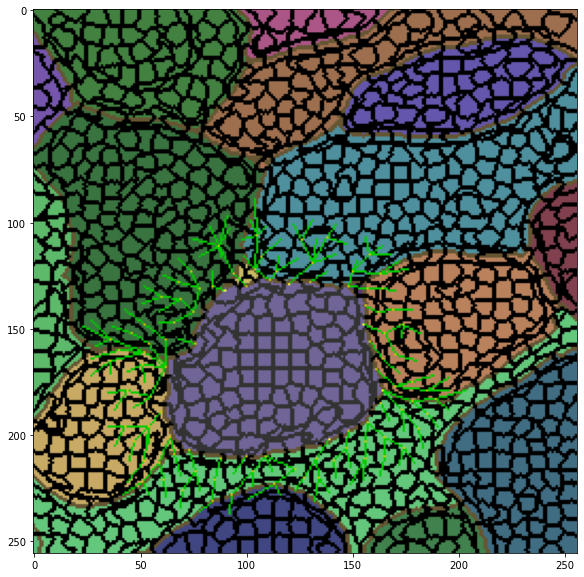

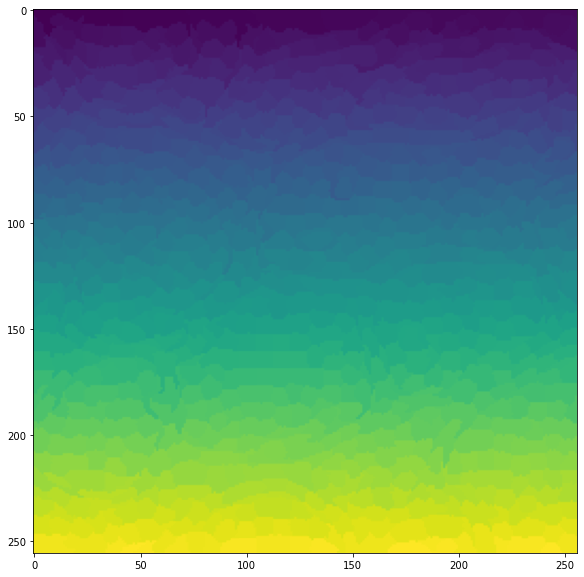

In [84]:
index = 14
edges_drawn_all = display_edges (label_rgb, rag.new_edges[index], 0.5, rag.rag)
highlight_segment = gray2rgb ((label==index).astype (np.float32))
tmp = (edges_drawn_all * 4 + highlight_segment) / 5
show_img (tmp, 10)
show_img (rag.segments, 10)

# Other functionalities

vec2image: 1D vector of values (eg. rewards, label, action) -> 2D image

In [88]:
tmp_values = [np.random.rand () for _ in range (rag.n_segments + 1)]
tmp_trans_img = rag.vec2img (np.array (tmp_values))
print ("shape after mapping", tmp_trans_img.shape)

shape after mapping (256, 256)


List of instance area and list of total neighboring area

In [89]:
print ("number of instances: ", len (rag.ins_area))
print ("area list:", rag.ins_area)
print ("neiboring area list:", rag.nei_area)

number of instances:  22
area list: [0, 3468, 4346, 989, 4315, 515, 3294, 8798, 8363, 10, 1698, 949, 4656, 60, 6520, 21, 6554, 3641, 4438, 1952, 927, 22]
neiboring area list: [0, 0, 5795.0, 3687.0, 9594.0, 2894.0, 7200.0, 12972.0, 11857.0, 3626.0, 5366.0, 3526.0, 8353.0, 4444.0, 11441.0, 3623.0, 14540.0, 6377.0, 4236.0, 4206.0, 3526.0, 960.0]
